# A/B-тестирование 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ab_data = pd.read_csv('data/ab_data.csv')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


 Итак, мы получили таблицу со следующими полями:
user_id	идентификатор пользователя, зашедшего на сайт
timestamp	дата события
group	группа теста (контрольная или тестовая)
converted	совершил пользователь целевое действие (нажатие кнопки «добавить в корзину» на сопутствующем товаре) или нет. 1 — да, 0 — нет.

In [3]:
ab_data.info() # посмотрим тип данных и содержание столбцов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [4]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')
# дату переведем в формат datetime

Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий. 

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() и переименуем столбец user_id в users_count с помощью метода rename().

In [5]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


Для завершения этапа подготовки данных к анализу нам осталось рассчитать конверсию на каждый день проведения A/B-тестирования. Напомним: ежедневная конверсия рассчитывается как отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия в день, к ежедневному общему числу посетителей сайта, умноженная на 100 %

In [6]:
daily_data['conversion'] = (daily_data['converted'] / daily_data['users_count']) * 100
daily_data.head()


,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


### Задание 4.1
Чему была равна конверсия (в процентах) в группе А 5 января 2017 года? Ответ округлите до второго знака после запятой

In [7]:
mask = (daily_data['timestamp'] == '2017-01-05') & (daily_data['group'] == 'A')
round(daily_data[mask]['conversion'], 2)

6    12.32
Name: conversion, dtype: float64

## Визуальный анализ конверсии в группах

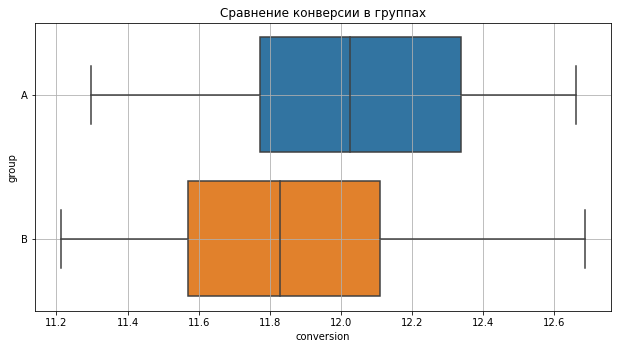

In [8]:
fig = plt.figure(figsize=(8, 4)) # создаём фигуру размером 8x4
ax = fig.add_axes([1, 1, 1, 1]) # добавляем систему координат 
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) # строим boxplot для conversion по признаку group 
ax.set_title('Сравнение конверсии в группах') # задаём подпись к графику
ax.grid() # задаём отображение сетки

Что можно сказать исходя из этого графика? Во-первых, медианное значение ежедневной конверсии в группе А, выше, чем в группе B. Во-вторых, разброс конверсии в группе B несколько больше, чем в группе A.

## Примечание. Прежде чем делать выводы по визуальному представлению данных, всегда обращайте внимание на численные значения показателей. Они могут различаться в масштабе графика, но на практике разница между ними не будет иметь значения. Также всегда стоит убедиться, что в данных нет выбросов (базовый вариант — сравнить медиану и среднее между собой). Далее мы ещё поговорим о стабилизации показателя во времени.

In [9]:
# вычислим среднее и медианное значение для каждой группы
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают. При этом разница между показателями в группах менее 0.3 %

In [10]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


А теперь построим графики кумулятивной конверсии по дням в каждой группе:

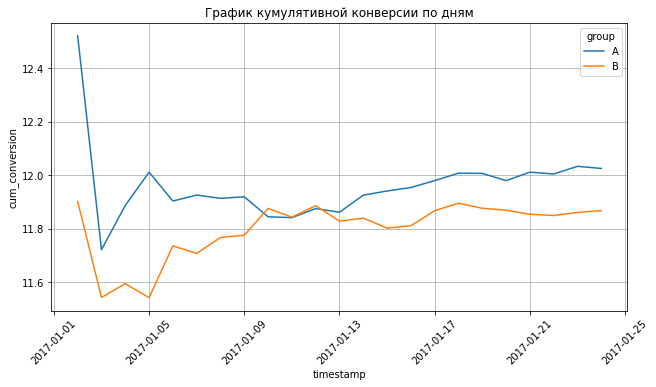

In [11]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True)

До 2017-01-09 конверсия была нестабильна, но после 2017-11-01 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. 
На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

## Задание 4.6
Проводится A/B-тестирование для двух вариантов дизайна сайта. Результаты тестирования собраны в двух файлах (данные для группы А и для группы B).
Каждая таблица имеет следующие поля:
date — дата наблюдения;
cid — идентификатор посетителя;
transactions — количество совершённых целевых действий (транзакций);
revenue — сумма покупки;
group — группа (тестовая — А, контрольная — B).
Постройте таблицу со следующими ежедневными показателями:
количество посетителей сайта;
суммарное число транзакций;
общая сумма покупок (выручка).
Для этого сгруппируйте данные по признаку date, предварительно преобразовав его к типу datetime.
Чему равны значения ежедневных показателей в группе А на 8 ноября 2020 года?
Количество посетителей сайта

In [12]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')

sample_a['date'] = pd.to_datetime(sample_a['date'])
sample_b['date'] = pd.to_datetime(sample_b['date'])

daily_sample_a = sample_a.groupby(['date']).agg({ # группировка по дате
    'cid':'count', # метод agg() - д/группировки с агрегациями, в него передаем словарь, 
    'transactions':'sum', # где ключ - имя столбца - название агрегатной функции
    'revenue':'sum'
}).reset_index().rename(columns={'cid': 'users_count'}) # сброс индексов, переименование столбца

daily_sample_b = sample_b.groupby(['date']).agg({
    'cid':'count',
    'transactions':'sum',
    'revenue':'sum'
}).reset_index().rename(columns={'cid': 'users_count'})

daily_sample_a[daily_sample_a['date'] == '2020-11-08']

,date,users_count,transactions,revenue
2,2020-11-08,3354,25,846051


## Задание 4.7
Добавьте в каждую из таблиц кумулятивные метрики:
кумулятивное количество посетителей сайта;
кумулятивное суммарное число транзакций;
кумулятивная общая сумма покупок (кумулятивная выручка).

Рассчитайте кумулятивную конверсию действия покупки (в процентах) и кумулятивный средний чек (кумулятивная выручка/кумулятивное суммарное число транзакций).

Чему равна средняя кумулятивная конверсия в группах за весь период проведения A/B-теста? Ответ округлите до сотых, знаки процентов не вводите.

In [14]:
# Для группы А
daily_sample_a['cum_users_count'] = daily_sample_a.groupby(['date'])['users_count'].cumsum()
# кумулятивное количество посетителей
daily_sample_a['cum_transactions'] = daily_sample_a.groupby(['date'])['transactions'].cumsum()
# кумулятивное число транзакций
daily_sample_a['cum_revenue'] = daily_sample_a.groupby(['date'])['revenue'].cumsum()
# кумулятивная выручка
daily_sample_a['cum_buy'] = daily_sample_a['cum_transactions'] / daily_sample_a['cum_users_count'] * 100
# кумулятивная конверсия действия покупки (в %)
daily_sample_a['cum_avg_check'] = daily_sample_a['cum_revenue'] / daily_sample_a['cum_transactions']
# кумулятивный средний чек
print('Средняя кумулятивная конверсия в группе А:', round((daily_sample_a['transactions']/daily_sample_a['cum_users_count']*100).mean(), 2))

# Для группы В
daily_sample_b['cum_users_count'] = daily_sample_b.groupby(['date'])['users_count'].cumsum()
# кумулятивное количество посетителей
daily_sample_b['cum_transactions'] = daily_sample_b.groupby(['date'])['transactions'].cumsum()
# кумулятивное число транзакций
daily_sample_b['cum_revenue'] = daily_sample_b.groupby(['date'])['revenue'].cumsum()
# кумулятивная выручка
daily_sample_b['cum_buy'] = daily_sample_b['cum_transactions'] / daily_sample_b['cum_users_count'] * 100
# кумулятивная конверсия действия покупки (в %)
daily_sample_a['cum_avg_check'] = daily_sample_b['cum_revenue'] / daily_sample_b['cum_transactions']
# кумулятивный средний чек
print('Средняя кумулятивная конверсия в группе B:', round((daily_sample_b['transactions']/daily_sample_b['cum_users_count']*100).mean(), 2))

Средняя кумулятивная конверсия в группе А: 0.72
Средняя кумулятивная конверсия в группе B: 0.76
